In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm

import matplotlib.pyplot as plt

from sklearn.cross_validation import train_test_split

from pprint import pprint as pp

pd.set_option('display.max_columns', 75)

%matplotlib inline

* load the data file
* we skip row 1 because it's a note that affects our headers.
* we only grab 235,629 rows because the last two rows are a single description in column 0.
* try it without each and see what happens.

In [2]:
dfLoanData = pd.read_csv('LoanStats3c.csv', skiprows=1, nrows=235629)

# It should still yell at us that the column 19 (aka 'desc') is also mixed type.
# so we drop that column - we're not using it anyway.
dfLoanData = dfLoanData.drop('desc', axis=1)

/Library/Python/2.7/site-packages/pandas/io/parsers.py:1164: DtypeWarning: Columns (19) have mixed types. Specify dtype option on import or set low_memory=False.
  data = self._reader.read(nrows)


In [3]:
dfLoanData['int_rate'] = dfLoanData.apply(lambda x: pd.Series(x['int_rate'].rstrip('%')).astype('float') / 100, axis=1)

* now we're ready to start thinking about the regression.
* first: interest rate is a string with a '%' symbol in it.
* use code you've already written to handle that.

* Income is already numeric, so you'll be fine there. You can begin to model that now.

* your first regression equation should be of the form:
 $$interest = intercept + constant1 * income$$

* use statsmodels and the same technique you used in the earlier linear regression to solve.

In [4]:
sample_size = int(len(dfLoanData) * .1)
index_list = np.random.choice(dfLoanData.index.tolist(), sample_size)

dfLoanDataSampled = dfLoanData.loc[index_list]
dfLoanDataSampled = dfLoanDataSampled[['annual_inc', 'int_rate', 'home_ownership']]

In [5]:
trainData, testData = train_test_split(dfLoanDataSampled, test_size=0.2)

In [6]:
pp(dfLoanDataSampled.shape)
pp(trainData.shape)
pp(testData.shape)
pp(len(trainData) + len(testData))

(23562, 3)
(18849, 3)
(4713, 3)
23562


In [7]:
X_train = trainData['annual_inc']
y_train = trainData['int_rate']

In [8]:
# fit a OLS model with intercept
X_train = sm.add_constant(X_train)
est = sm.OLS(y_train, X_train).fit()

In [9]:
est.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               int_rate   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     45.61
Date:                Tue, 14 Apr 2015   Prob (F-statistic):           1.49e-11
Time:                        21:50:23   Log-Likelihood:                 32703.
No. Observations:               18849   AIC:                        -6.540e+04
Df Residuals:                   18847   BIC:                        -6.539e+04
Df Model:                           1                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const          0.1390      0.000    345.472      0.000         0.138     0.140
annual_inc -2.291e-08   3.39e-09     -6.753      0.000     -2.96e-08 -1.63e-08
==============================================================================
Omnibus:                      484.179   Durbin-Watson:                   2.000
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              522.164
Skew:                           0.408   Prob(JB):                    4.11e-114
Kurtosis:                       2.987   Cond. No.                     1.54e+05
==============================================================================

Warnings:
[1] The condition number is large, 1.54e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

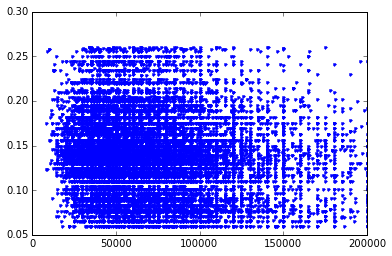

In [27]:
plt.plot(trainData['annual_inc'],trainData['int_rate'], '.')
plt.xlim(0, 200000)
plt.show()

* next one is home ownership. These are categorical variables, so you need to

* for a really good summary of multiple regression with statsmodels and the theory
* behind it, read this post: [Logistic Regression](http://blog.yhathq.com/posts/logistic-regression-and-python.html)

In [28]:
dfDummies = pd.get_dummies(trainData['home_ownership'])
trainData = pd.merge(trainData, dfDummies, left_index=True, right_index=True)

In [30]:
trainData.rename(columns={'MORTGAGE_x':'MORTGAGE', 'OWN_x':'OWN', 'RENT_x':'RENT'}, inplace=True)
trainData = trainData[['annual_inc', 'int_rate', 'home_ownership', 'MORTGAGE', 'OWN', 'RENT']]
trainData.head(25)

,annual_inc,int_rate,home_ownership,MORTGAGE,OWN,RENT
8,72000,0.1431,RENT,0,0,1
9,55000,0.2199,MORTGAGE,1,0,0
17,60000,0.1049,RENT,0,0,1
56,48500,0.0819,MORTGAGE,1,0,0
62,34000,0.1499,OWN,0,1,0
69,80000,0.1144,MORTGAGE,1,0,0
74,40000,0.1199,RENT,0,0,1
81,33000,0.1144,MORTGAGE,1,0,0
85,74500,0.1714,RENT,0,0,1
88,68000,0.1299,RENT,0,0,1


In [31]:
# 'Logistic Regression - No Interactions'
X_logit_train = trainData[['annual_inc', 'MORTGAGE', 'RENT', 'OWN']]
y_logit_train = trainData['int_rate']

In [32]:
logit = sm.Logit(y_logit_train, X_logit_train)
result = logit.fit()

result.summary()

Optimization terminated successfully.
         Current function value: 0.235514
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:               int_rate   No. Observations:                29335
Model:                          Logit   Df Residuals:                    29331
Method:                           MLE   Df Model:                            3
Date:                Tue, 14 Apr 2015   Pseudo R-squ.:               3.840e-05
Time:                        21:57:18   Log-Likelihood:                -6908.8
converged:                       True   LL-Null:                       -6909.1
                                        LLR p-value:                    0.9121
==============================================================================
                 coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
annual_inc -3.368e-07   3.27e-07     -1.031      0.302     -9.77e-07  3.03e-07
MORTGAGE      -1.8346      0.037    -50.259      0.000        -1.906    -1.763
RENT          -1.7967      0.034    -53.376      0.000        -1.863    -1.731
OWN           -1.7891      0.057    -31.126      0.000        -1.902    -1.676
==============================================================================
"""

In [34]:
print "confidence interval"
print result.conf_int()

print "odds ratios"
print np.exp(result.params)

print "odds ratios and 95% confidence intervals"
params = result.params
conf = result.conf_int()
conf['OR'] = params
conf.columns = ['2.5%', '97.5%', 'OR']
print np.exp(conf)

confidence interval
                   0         1
annual_inc -0.000001  0.000000
MORTGAGE   -1.906174 -1.763082
RENT       -1.862723 -1.730770
OWN        -1.901732 -1.676419
odds ratios
annual_inc    1.000000
MORTGAGE      0.159673
RENT          0.165838
OWN           0.167115
dtype: float64
odds ratios and 95% confidence intervals
                2.5%     97.5%        OR
annual_inc  0.999999  1.000000  1.000000
MORTGAGE    0.148648  0.171516  0.159673
RENT        0.155249  0.177148  0.165838
OWN         0.149310  0.187043  0.167115


In [35]:
dfDummiesTest = pd.get_dummies(testData['home_ownership'])
testData = pd.merge(testData, dfDummiesTest, left_index=True, right_index=True)

In [38]:
testData.rename(columns={'MORTGAGE_x':'MORTGAGE', 'OWN_x':'OWN', 'RENT_x':'RENT'}, inplace=True)
testData = trainData[['annual_inc', 'int_rate', 'home_ownership', 'MORTGAGE', 'OWN', 'RENT']]
testData.head(25)

,annual_inc,int_rate,home_ownership,MORTGAGE,OWN,RENT
8,72000,0.1431,RENT,0,0,1
9,55000,0.2199,MORTGAGE,1,0,0
17,60000,0.1049,RENT,0,0,1
56,48500,0.0819,MORTGAGE,1,0,0
62,34000,0.1499,OWN,0,1,0
69,80000,0.1144,MORTGAGE,1,0,0
74,40000,0.1199,RENT,0,0,1
81,33000,0.1144,MORTGAGE,1,0,0
85,74500,0.1714,RENT,0,0,1
88,68000,0.1299,RENT,0,0,1


In [39]:
X_logit_test = testData[['annual_inc', 'MORTGAGE', 'RENT', 'OWN']]

In [41]:
# Now model the interaction between income and home ownership
#trainData['income_ANY'] = trainData.apply(lambda x: x['annual_inc'] * x['ANY'], axis = 1)
trainData['income_MORTGAGE'] = trainData.apply(lambda x: x['annual_inc'] * x['MORTGAGE'], axis = 1)
trainData['income_OWN'] = trainData.apply(lambda x: x['annual_inc'] * x['OWN'], axis = 1)
trainData['income_RENT'] = trainData.apply(lambda x: x['annual_inc'] * x['RENT'], axis = 1)

X_train2 = trainData[['income_MORTGAGE', 'income_RENT', 'income_OWN']]

logit2 = sm.Logit(y_train, X_train2)
result2 = logit2.fit()

print result2.summary()

print "confidence interval"
print result2.conf_int()

print "odds ratios"
print np.exp(result2.params)

print "odds ratios and 95% confidence intervals"
params2 = result2.params
conf2 = result2.conf_int()
conf2['OR'] = params
conf2.columns = ['2.5%', '97.5%', 'OR']
print np.exp(conf2)

ValueError: The indices for endog and exog are not aligned